# **Assignment 5.1: Topic Modeling**

#### **Course:** ADS 509, Applied Large Language Models for Data Science

#### **Name:** Anna Shekikyan

#### **Date:** 10/06/2025

#### **GitHub:** https://github.com/AnahitShekikyan/ADS-509-Assignment-5.1-Topic-Modeling-

In [1]:
import nltk
try:
    from nltk.corpus import brown
    _ = brown.categories()
except LookupError:
    nltk.download("brown")
    nltk.download("stopwords")
    from nltk.corpus import brown  # re-import after download

In [2]:
# These libraries may be useful to you

#!pip install pyLDAvis
#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    homogeneity_score, completeness_score, v_measure_score,
    adjusted_rand_score, adjusted_mutual_info_score
)

In [5]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [6]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [7]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [8]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

<Axes: xlabel='category'>

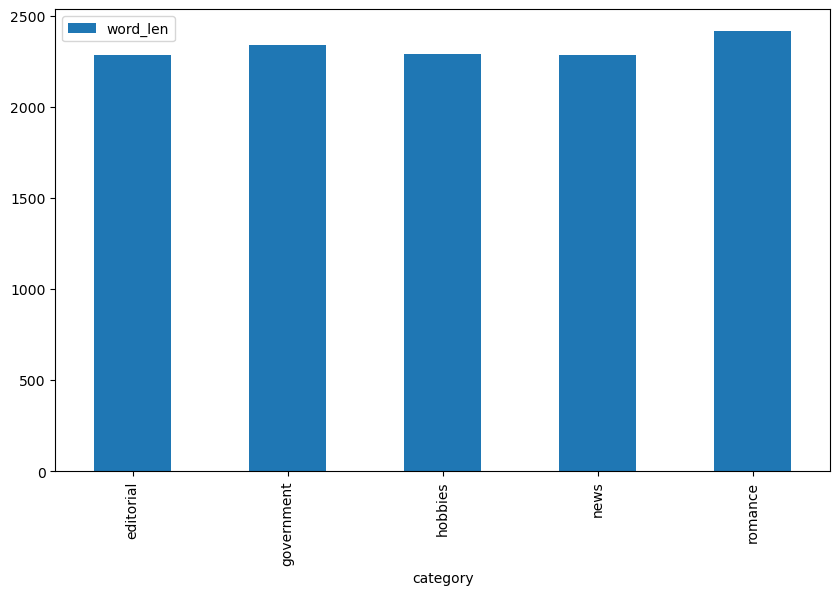

In [9]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

In [12]:
stopwords |= {"ll","ve"} # for warnings

Now do our TF-IDF and Count vectorizations.

In [13]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4939)

In [14]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4939)

**Q:** What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

**A:** `count_text_vectors` is a sparse document–term count matrix (SciPy CSR). Each row is a document (here, 166 Brown texts), each column a vocabulary term (after stopwording and min/max df pruning), and each cell holds the integer frequency of that term in that document.
`tfidf_text_vectors` has the same shape but stores TF–IDF–weighted floats instead of raw counts (down-weighting common terms, up-weighting discriminative ones, L2-normalized by default in `TfidfVectorizer`).

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [15]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [16]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.89)
  didn (0.46)
  thought (0.42)
  man (0.38)
  don (0.35)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.63)
  mr (0.79)
  said (0.63)
  miss (0.53)
  car (0.51)

Topic 04
  game (1.02)
  league (0.75)
  ball (0.73)
  baseball (0.71)
  team (0.67)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 

In [18]:
# NMF vs. Brown categories, dominant topic, cross-tab, and metrics 

# dominant NMF topic for each document
nmf_dom = W_text_matrix.argmax(axis=1)

# cross-tab: which Brown categories fall into each topic?
nmf_crosstab = pd.crosstab(
    pd.Series(nmf_dom, name="NMF topic"),
    pd.Series(df["category"], name="Brown category")
)
display(nmf_crosstab)

# row-normalized percentages for readability
display(nmf_crosstab.div(nmf_crosstab.sum(axis=1), axis=0).round(2))

# unsupervised clustering metrics vs. gold labels (Brown categories)
label_to_int = {c:i for i,c in enumerate(sorted(df["category"].unique()))}
y_true = df["category"].map(label_to_int).values
y_pred = nmf_dom

print("Homogeneity:", round(homogeneity_score(y_true, y_pred), 3))
print("Completeness:", round(completeness_score(y_true, y_pred), 3))
print("V-measure:", round(v_measure_score(y_true, y_pred), 3))
print("Adjusted Rand Index:", round(adjusted_rand_score(y_true, y_pred), 3))
print("Adjusted Mutual Info:", round(adjusted_mutual_info_score(y_true, y_pred), 3))

Brown category,editorial,government,hobbies,news,romance
NMF topic,,,,,
0,20,4,0,8,0
1,4,0,8,0,29
2,2,26,26,11,0
3,0,0,1,17,0
4,1,0,1,8,0


Brown category,editorial,government,hobbies,news,romance
NMF topic,,,,,
0,0.62,0.12,0.00,0.25,0.00
1,0.10,0.00,0.20,0.00,0.71
2,0.03,0.40,0.40,0.17,0.00
3,0.00,0.00,0.06,0.94,0.00
4,0.10,0.00,0.10,0.80,0.00


Homogeneity: 0.449
Completeness: 0.497
V-measure: 0.472
Adjusted Rand Index: 0.329
Adjusted Mutual Info: 0.453


**Q:** How does your five-topic NMF model compare to the original Brown categories? 

**A:** T3 and T4 map to news; T0 maps mostly to editorial; T1 maps to romance; T2 is mixed (government + hobbies). Overall match is moderate (V-measure 0.472, ARI 0.329).

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [20]:
# LSA
lsa_k = 5
svd = TruncatedSVD(n_components=lsa_k, random_state=314)
lsa_doc_topic = svd.fit_transform(tfidf_text_vectors)   # doc x k (component scores)

# top terms per LSA component (by absolute loading)
terms = tfidf_text_vectorizer.get_feature_names_out()
for k, row in enumerate(svd.components_):
    idx = np.argsort(np.abs(row))[::-1][:10]
    tops = [f"{terms[i]}" for i in idx]
    print(f"LSA Topic {k:02d}: " + ", ".join(tops))

# dominant component per doc
lsa_dom = lsa_doc_topic.argmax(axis=1)

# cross-tab vs. brown categories
lsa_crosstab = pd.crosstab(
    pd.Series(lsa_dom, name="LSA topic"),
    pd.Series(df["category"], name="Brown category")
)
display(lsa_crosstab)
display(lsa_crosstab.div(lsa_crosstab.sum(axis=1), axis=0).round(2))  # row-normalized

# unsupervised clustering metrics
label_to_int = {c:i for i,c in enumerate(sorted(df["category"].unique()))}
y_true = df["category"].map(label_to_int).values
y_pred_lsa = lsa_dom

print("Homogeneity:", round(homogeneity_score(y_true, y_pred_lsa), 3))
print("Completeness:", round(completeness_score(y_true, y_pred_lsa), 3))
print("V-measure:", round(v_measure_score(y_true, y_pred_lsa), 3))
print("Adjusted Rand Index:", round(adjusted_rand_score(y_true, y_pred_lsa), 3))
print("Adjusted Mutual Info:", round(adjusted_mutual_info_score(y_true, y_pred_lsa), 3))

LSA Topic 00: said, mr, mrs, state, man, president, 000, united, old, american
LSA Topic 01: said, state, didn, thought, united, states, mrs, got, don, looked
LSA Topic 02: mrs, mr, said, af, development, water, kennedy, khrushchev, laos, president
LSA Topic 03: mrs, khrushchev, berlin, soviet, kennedy, club, game, united, laos, jr
LSA Topic 04: game, mrs, league, baseball, ball, team, runs, player, tax, yankees


Brown category,editorial,government,hobbies,news,romance
LSA topic,,,,,
0,27,30,36,34,21
1,0,0,0,0,8
3,0,0,0,3,0
4,0,0,0,7,0


Brown category,editorial,government,hobbies,news,romance
LSA topic,,,,,
0,0.18,0.2,0.24,0.23,0.14
1,0.00,0.0,0.00,0.00,1.00
3,0.00,0.0,0.00,1.00,0.00
4,0.00,0.0,0.00,1.00,0.00


Homogeneity: 0.108
Completeness: 0.38
V-measure: 0.169
Adjusted Rand Index: 0.006
Adjusted Mutual Info: 0.132


**Q:** How does your five-topic LSA model compare to the original Brown categories? 

**A:** T1 maps cleanly to romance, T3 and T4 capture small news slices, and T0 is broadly mixed across all categories; overall alignment is weak (V-measure 0.169, ARI 0.006).

In [21]:
# call display_topics 
display_topics(svd, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=10)


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)
  president (0.16)
  000 (0.15)
  united (0.14)
  old (0.14)
  american (0.14)

Topic 01
  said (4.32)
  didn (2.89)
  thought (2.42)
  mrs (2.18)
  got (2.16)
  don (2.10)
  looked (2.00)
  mother (1.96)
  eyes (1.89)
  went (1.87)

Topic 02
  mrs (3.09)
  mr (1.69)
  said (1.03)
  kennedy (0.81)
  khrushchev (0.76)
  laos (0.75)
  president (0.75)
  committee (0.68)
  berlin (0.65)
  party (0.65)

Topic 03
  mrs (26.98)
  club (6.09)
  game (5.92)
  jr (5.14)
  university (4.80)
  dallas (4.75)
  home (4.66)
  season (4.63)
  league (4.52)
  miss (4.52)

Topic 04
  game (4.66)
  league (3.34)
  baseball (3.30)
  ball (3.20)
  team (3.02)
  runs (2.93)
  player (2.58)
  yankees (2.48)
  season (2.35)
  hit (2.30)


**Q:** What is your interpretation of the display topics output? 

**A:** T04 clearly captures sports/hobbies vocabulary (game, league, baseball, team, yankees). T03 leans leisure/sports with social context (club, league, season, names), so a hobbies/news mix. T02 reflects government/Cold War politics (kennedy, khrushchev, berlin, committee). T01 reads as narrative/romance language (didn, thought, mother, eyes, went). T00 is a broad editorial/news axis with general reportage terms (said, state, president, united), so it’s mixed.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [22]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(
    n_components=5,
    learning_method="batch",
    max_iter=50,
    random_state=314
)
lda_text_model.fit(count_text_vectors)

LatentDirichletAllocation(max_iter=50, n_components=5, random_state=314)

In [23]:
# display_topics
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out(), no_top_words=10)


Topic 00
  state (1.23)
  states (0.85)
  development (0.72)
  tax (0.71)
  government (0.61)
  business (0.61)
  sales (0.56)
  united (0.55)
  fiscal (0.51)
  program (0.50)

Topic 01
  said (1.46)
  mrs (0.92)
  old (0.62)
  man (0.53)
  little (0.49)
  good (0.45)
  day (0.43)
  know (0.43)
  got (0.41)
  way (0.40)

Topic 02
  said (0.68)
  mr (0.65)
  president (0.62)
  state (0.50)
  american (0.44)
  united (0.41)
  world (0.37)
  states (0.35)
  000 (0.34)
  government (0.33)

Topic 03
  af (0.69)
  design (0.60)
  forces (0.47)
  aircraft (0.47)
  pieces (0.45)
  bridge (0.44)
  medical (0.41)
  missile (0.40)
  pressure (0.40)
  form (0.39)

Topic 04
  feed (0.52)
  use (0.51)
  water (0.44)
  clay (0.44)
  game (0.43)
  good (0.40)
  home (0.38)
  national (0.35)
  brown (0.34)
  area (0.34)


In [24]:
# LDA: dominant topic per doc, cross-tab vs Brown, and metrics
lda_doc_topic = lda_text_model.transform(count_text_vectors)
lda_dom = lda_doc_topic.argmax(axis=1)

lda_crosstab = pd.crosstab(
    pd.Series(lda_dom, name="LDA topic"),
    pd.Series(df["category"], name="Brown category")
)
display(lda_crosstab)
display(lda_crosstab.div(lda_crosstab.sum(axis=1), axis=0).round(2))

from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
label_to_int = {c:i for i,c in enumerate(sorted(df["category"].unique()))}
y_true = df["category"].map(label_to_int).values
y_pred_lda = lda_dom

print("Homogeneity:", round(homogeneity_score(y_true, y_pred_lda), 3))
print("Completeness:", round(completeness_score(y_true, y_pred_lda), 3))
print("V-measure:", round(v_measure_score(y_true, y_pred_lda), 3))
print("Adjusted Rand Index:", round(adjusted_rand_score(y_true, y_pred_lda), 3))
print("Adjusted Mutual Info:", round(adjusted_mutual_info_score(y_true, y_pred_lda), 3))

Brown category,editorial,government,hobbies,news,romance
LDA topic,,,,,
0,0,17,2,2,0
1,5,0,4,7,29
2,22,10,2,28,0
3,0,2,10,0,0
4,0,1,18,7,0


Brown category,editorial,government,hobbies,news,romance
LDA topic,,,,,
0,0.00,0.81,0.10,0.10,0.00
1,0.11,0.00,0.09,0.16,0.64
2,0.35,0.16,0.03,0.45,0.00
3,0.00,0.17,0.83,0.00,0.00
4,0.00,0.04,0.69,0.27,0.00


Homogeneity: 0.417
Completeness: 0.454
V-measure: 0.435
Adjusted Rand Index: 0.311
Adjusted Mutual Info: 0.415


**Q:** What inference do you draw from the displayed topics for your LDA model? 

**A:** T0 is government/economy, T2 is news/politics, T1 is narrative/romance/editorial, T3 is hobbies/technical, and T4 is hobbies/sports. Topics are coherent and distinct. 

**Q:** Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

**A:** T0 → government, T1 → romance (with some news), T2 → news (with some editorial), T3 → hobbies, T4 → hobbies (with some news). Overall match is moderate (V-measure 0.435, ARI 0.311).

In [25]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [27]:
pyLDAvis.display(lda_display)

**Q:** What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

**A:** Topic circles show substantial separation, indicating distinct vocabularies across topics. Two hobbies/sports circles cluster closely, reflecting shared terms such as “game” and “league.” News/politics and government/economy circles occupy regions distant from the narrative/romance circle, signaling divergent word usage. Circle area denotes topic prevalence; inter-circle distance encodes dissimilarity.        

Salient-terms panel: Bars report high-relevance words per topic. Large λ values emphasize frequent words; small λ values emphasize topic-unique words. Government/economy shows “state, tax, development.” News/politics shows “president, united, american.” Narrative/romance shows “said, mrs, man/old.” Hobbies/sports topics show “game, league, baseball,” and a technical-leisure topic shows “aircraft, forces, bridge.”